In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import xgboost as xgb

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import TWO_LAYERS_ZEE, FIVE_LAYERS
from events_package.atlas_geo import ATLAS_GEOMETRY
from events_package.input_getters import get_Y_2, get_X_5

# 1. Importing Z -> ee Data

In [2]:
# Import data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Zee\zee_pq"
)
Zee = Experiment(dataset_df, config=TWO_LAYERS_ZEE)
Zee.length

46679

In [3]:
Zee.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 46668
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 46668


In [4]:
# as mentioned before fake etas in missing layers are added such that eta from missing layer is in agreement with emb2 eta
fake_psb_etas = []
fake_emb3_etas = []
fake_hab1_etas = []

for i in range(Zee.length):
    fake_psb_etas.append(
        utils.closest_value(Zee.emb2_eta.values[i], ATLAS_GEOMETRY.psb_eta)
    )
    fake_emb3_etas.append(
        utils.closest_value(Zee.emb2_eta.values[i], ATLAS_GEOMETRY.emb3_eta)
    )
    fake_hab1_etas.append(
        utils.closest_value(Zee.emb2_eta.values[i], ATLAS_GEOMETRY.hab1_eta)
    )


fake_data = {
    "fake_psb_etas": fake_psb_etas,
    "fake_emb3_etas": fake_emb3_etas,
    "fake_hab1_etas": fake_hab1_etas,
}


df1 = pd.DataFrame(fake_data)

In [5]:
Zee.dataset = pd.concat([Zee.dataset, df1], axis=1)
Zee.dataset[:10]

,event_no,candidate_no,z,et,eta,phi,emb1_eta,emb1_phi,emb2_eta,emb2_phi,...,"emb2_(6,3)","emb2_(6,4)","emb2_(6,5)","emb2_(6,6)","emb2_(6,7)","emb2_(6,8)",tot_layers_et,fake_psb_etas,fake_emb3_etas,fake_hab1_etas
0,4124.0,0.0,-21.090054,40174.152,0.493212,2.105485,0.479912,2.110758,0.490994,2.123029,...,17.091366,0.000000,0.000000,0.000000,126.168750,0.000000,37960.389875,0.490994,0.478405,0.453225
1,881.0,0.0,43.694988,48442.043,0.449666,1.295134,0.473659,1.325359,0.465815,1.313088,...,4.653037,0.000000,0.000000,0.000000,0.000000,0.000000,44642.274873,0.465815,0.478405,0.453225
2,34273.0,1.0,0.333809,39336.371,0.302678,1.406651,0.301704,1.423534,0.314740,1.386719,...,302.274020,37.285393,40.632824,0.000000,0.000000,0.000000,34190.249059,0.314740,0.327329,0.352509
3,8525.0,1.0,-31.080210,60702.957,-0.346496,-0.730959,-0.364233,-0.736311,-0.365098,-0.724039,...,54.741745,319.637360,13.177662,55.357597,0.000000,0.000000,56666.980874,-0.365098,-0.377688,-0.352509
4,13171.0,0.0,-5.972441,38315.375,-1.010549,0.086893,-1.011411,0.049087,-1.019757,0.085903,...,96.804779,134.054120,23.641773,82.749840,24.539736,0.000000,35194.388360,-1.019757,-1.032347,-0.956809
5,61076.0,0.0,-15.216010,16913.746,-0.832056,0.244003,-0.839455,0.245437,-0.843503,0.282252,...,10.097306,41.465466,20.568159,82.873756,171.945390,41.543083,13844.563449,-0.843503,-0.830913,-0.856092
6,66198.0,1.0,-23.288046,36751.637,1.330261,2.281899,1.320930,2.307107,1.321907,2.294835,...,0.000000,0.000000,41.600204,0.000000,0.000000,0.000000,25577.658480,1.321907,1.334497,1.359676
7,26786.0,1.0,-17.841692,18776.055,0.555841,-1.791553,0.545568,-1.816233,0.541353,-1.754874,...,0.000000,0.000000,11.194204,0.000000,0.000000,0.000000,20638.666692,0.541353,0.528763,0.553942
8,65811.0,0.0,54.838470,38878.797,0.530439,-0.999336,0.561200,-1.030835,0.566532,-0.994020,...,280.941100,11.979493,87.116470,21.216003,0.000000,62.518154,34700.377704,0.566532,0.579121,0.553942
9,67669.0,0.0,-51.663815,42922.344,-0.650165,-2.608935,-0.676879,-2.601631,-0.692428,-2.613903,...,0.000000,0.000000,0.000000,117.122650,0.000000,0.000000,37942.304796,-0.692428,-0.679838,-0.654659


In [6]:
current_directory = os.getcwd()
models_directory = os.path.join(current_directory, "..", "models")
filename = "model_1899_quantised_256.pkl"
model_path = os.path.join(models_directory, filename)

# Load the saved model
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

In [7]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=100000, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.74, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

In [8]:
mappings = utils.import_mappings()

In [9]:
mappings

{'psb_mapping': {-1.4226241: 0,
  -1.3974449: 1,
  -1.3722657: 2,
  -1.3470865: 3,
  -1.3219073: 4,
  -1.2967282: 5,
  -1.271549: 6,
  -1.2463698: 7,
  -1.2211906: 8,
  -1.1960114: 9,
  -1.1708322: 10,
  -1.145653: 11,
  -1.1204738: 12,
  -1.0952947: 13,
  -1.0701155: 14,
  -1.0449363: 15,
  -1.0197571: 16,
  -0.99457791: 17,
  -0.96939872: 18,
  -0.94421953: 19,
  -0.91904034: 20,
  -0.89386116: 21,
  -0.86868197: 22,
  -0.84350278: 23,
  -0.81832359: 24,
  -0.79314441: 25,
  -0.76796522: 26,
  -0.74278603: 27,
  -0.71760684: 28,
  -0.69242766: 29,
  -0.66724847: 30,
  -0.64206928: 31,
  -0.61689009: 32,
  -0.59171091: 33,
  -0.56653172: 34,
  -0.54135253: 35,
  -0.51617334: 36,
  -0.49099416: 37,
  -0.46581497: 38,
  -0.44063578: 39,
  -0.41545659: 40,
  -0.39027741: 41,
  -0.36509822: 42,
  -0.33991903: 43,
  -0.31473984: 44,
  -0.28956066: 45,
  -0.26438147: 46,
  -0.23920228: 47,
  -0.21402309: 48,
  -0.18884391: 49,
  -0.16366472: 50,
  -0.13848553: 51,
  -0.11330634: 52,
  -0.08

In [10]:
# Convert values to float16
mappings_float16 = {
    key: utils.convert_values_to_float16(value) for key, value in mappings.items()
}

# Now you can access each mapping using its key in the mappings_float16 dictionary
psb_mapping = mappings_float16["psb_mapping"]
emb1_mapping = mappings_float16["emb1_mapping"]
emb2_mapping = mappings_float16["emb2_mapping"]
emb3_mapping = mappings_float16["emb3_mapping"]
hab1_mapping = mappings_float16["hab1_mapping"]

In [11]:
psb_mapping = {np.float16(float(key)): value for key, value in psb_mapping.items()}

print(psb_mapping)

{-1.423: 0.0, -1.397: 1.0, -1.372: 2.0, -1.347: 3.0, -1.322: 4.0, -1.297: 5.0, -1.271: 6.0, -1.246: 7.0, -1.221: 8.0, -1.196: 9.0, -1.171: 10.0, -1.1455: 11.0, -1.12: 12.0, -1.096: 13.0, -1.07: 14.0, -1.045: 15.0, -1.02: 16.0, -0.9946: 17.0, -0.969: 18.0, -0.9443: 19.0, -0.919: 20.0, -0.894: 21.0, -0.8687: 22.0, -0.8433: 23.0, -0.8184: 24.0, -0.793: 25.0, -0.768: 26.0, -0.7427: 27.0, -0.718: 28.0, -0.6924: 29.0, -0.6675: 30.0, -0.642: 31.0, -0.6167: 32.0, -0.592: 33.0, -0.5664: 34.0, -0.5415: 35.0, -0.516: 36.0, -0.491: 37.0, -0.4658: 38.0, -0.4407: 39.0, -0.4155: 40.0, -0.3904: 41.0, -0.365: 42.0, -0.3398: 43.0, -0.3147: 44.0, -0.2896: 45.0, -0.2644: 46.0, -0.2393: 47.0, -0.214: 48.0, -0.1888: 49.0, -0.1637: 50.0, -0.1384: 51.0, -0.1133: 52.0, -0.08813: 53.0, -0.0629: 54.0, -0.03778: 55.0, -0.01259: 56.0, 0.01259: 57.0, 0.03778: 58.0, 0.0629: 59.0, 0.08813: 60.0, 0.1133: 61.0, 0.1384: 62.0, 0.1637: 63.0, 0.1888: 64.0, 0.214: 65.0, 0.2393: 66.0, 0.2644: 67.0, 0.2896: 68.0, 0.3147: 69.0

In [12]:
emb1_mapping = {np.float16(float(key)): value for key, value in emb1_mapping.items()}

emb2_mapping = {np.float16(float(key)): value for key, value in emb2_mapping.items()}

emb3_mapping = {np.float16(float(key)): value for key, value in emb3_mapping.items()}

hab1_mapping = {np.float16(float(key)): value for key, value in hab1_mapping.items()}

In [13]:
bin_functions = utils.import_bin_functions()

In [14]:
# unpack quantisations
diff1_q, diff2_q, diff3_q, diff4_q = (
    bin_functions["q5"],
    bin_functions["q6"],
    bin_functions["q7"],
    bin_functions["q8"],
)

# unpack the rest
for i in range(9, 22):
    globals()[f"q{i}"] = bin_functions[f"q{i}"]

In [15]:
def get_X_5_quant_twolayer(dataframe):
    """Quantising etas and ata diffs."""
    s = dataframe.shape[0]  # number of rows (events)

    psb_info = np.zeros((s, 2))  # instead of 2 energy inputs, we take zeros
    emb1_info = np.sum(dataframe["emb1_cells"].values.reshape(s, 3, 17), axis=1)
    emb2_info = np.sum(dataframe["emb2_cells"].values.reshape(s, 7, 9), axis=1)
    emb3_info = np.zeros((s, 2))  # instead of 2 energy inputs, we take zeros
    hab1_info = np.zeros((s, 2))  # instead of 2 energy inputs, we take zeros

    emb1_tot = np.sum(emb1_info, axis=1)
    emb2_tot = np.sum(emb2_info, axis=1)
    en_tot = emb1_tot + emb2_tot

    emb1_info = utils.fold_list_2d(emb1_info) / en_tot[:, np.newaxis]
    emb2_info = utils.fold_list_2d(emb2_info) / en_tot[:, np.newaxis]

    v9 = psb_info.T[0]  # just 0
    v10 = psb_info.T[1]  # 0 - 0 will be still 0
    v11 = emb1_info.T[0]
    v12 = emb1_info.T[1]
    v13 = emb1_info.T[2]
    v14 = emb1_info.T[3]
    v15 = emb1_info.T[4]
    v16 = emb2_info.T[0]
    v17 = emb2_info.T[1]
    v18 = emb3_info.T[0]
    v19 = emb3_info.T[1]
    v20 = hab1_info.T[0]
    v21 = hab1_info.T[1]
    in9 = np.array([q9.bin_function(val) for val in v9])
    in10 = np.array([q10.bin_function(val) for val in v10])
    in11 = np.array([q11.bin_function(val) for val in v11])
    in12 = np.array([q12.bin_function(val) for val in v12])
    in13 = np.array([q13.bin_function(val) for val in v13])
    in14 = np.array([q14.bin_function(val) for val in v14])
    in15 = np.array([q15.bin_function(val) for val in v15])
    in16 = np.array([q16.bin_function(val) for val in v16])
    in17 = np.array([q17.bin_function(val) for val in v17])
    in18 = np.array([q18.bin_function(val) for val in v18])
    in19 = np.array([q19.bin_function(val) for val in v19])
    in20 = np.array([q20.bin_function(val) for val in v20])
    in21 = np.array([q21.bin_function(val) for val in v21])

    # eta mappings
    psb_eta_info = np.array(
        [psb_mapping[val] for val in dataframe.fake_psb_etas.values.astype("float16")]
    )
    emb1_eta_info = np.array(
        [emb1_mapping[val] for val in dataframe.emb1_eta.values.astype("float16")]
    )
    emb2_eta_info = np.array(
        [emb2_mapping[val] for val in dataframe.emb2_eta.values.astype("float16")]
    )
    emb3_eta_info = np.array(
        [emb3_mapping[val] for val in dataframe.fake_emb3_etas.values.astype("float16")]
    )
    hab1_eta_info = np.array(
        [hab1_mapping[val] for val in dataframe.fake_hab1_etas.values.astype("float16")]
    )

    diffs_exact_1 = dataframe.fake_psb_etas.values.astype(
        "float16"
    ) - dataframe.emb1_eta.values.astype("float16")
    diffs_exact_2 = dataframe.emb1_eta.values.astype(
        "float16"
    ) - dataframe.emb2_eta.values.astype("float16")
    diffs_exact_3 = dataframe.emb2_eta.values.astype(
        "float16"
    ) - dataframe.fake_emb3_etas.values.astype("float16")
    diffs_exact_4 = dataframe.fake_emb3_etas.values.astype(
        "float16"
    ) - dataframe.fake_hab1_etas.values.astype("float16")

    diff1_info = np.array([diff1_q.bin_function(val) for val in diffs_exact_1])
    diff2_info = np.array([diff2_q.bin_function(val) for val in diffs_exact_2])
    diff3_info = np.array([diff3_q.bin_function(val) for val in diffs_exact_3])
    diff4_info = np.array([diff4_q.bin_function(val) for val in diffs_exact_4])

    X1 = np.hstack(
        (
            psb_eta_info.reshape(-1, 1).astype("int16"),
            emb1_eta_info.reshape(-1, 1).astype("int16"),
            emb2_eta_info.reshape(-1, 1).astype("int16"),
            emb3_eta_info.reshape(-1, 1).astype("int16"),
            hab1_eta_info.reshape(-1, 1).astype("int16"),
            #########################################
            diff1_info.reshape(-1, 1).astype("int16"),
            diff2_info.reshape(-1, 1).astype("int16"),
            diff3_info.reshape(-1, 1).astype("int16"),
            diff4_info.reshape(-1, 1).astype("int16"),
            ###########################################
            in9.reshape(-1, 1).astype("int16"),
            in10.reshape(-1, 1).astype("int16"),
            in11.reshape(-1, 1).astype("int16"),
            in12.reshape(-1, 1).astype("int16"),
            in13.reshape(-1, 1).astype("int16"),
            in14.reshape(-1, 1).astype("int16"),
            in15.reshape(-1, 1).astype("int16"),
            in16.reshape(-1, 1).astype("int16"),
            in17.reshape(-1, 1).astype("int16"),
            in18.reshape(-1, 1).astype("int16"),
            in19.reshape(-1, 1).astype("int16"),
            in20.reshape(-1, 1).astype("int16"),
            in21.reshape(-1, 1).astype("int16"),
        )
    )

    return X1

In [16]:
Zee.train_test_split(get_X=get_X_5_quant_twolayer, get_Y=get_Y_2, test_size=1)
print(Zee.X_test.shape)

(46668, 22)


In [17]:
Zee.model = loaded_model

# test loaded model on Zee data:
Zee.test_model()  # 2052.961181640625

INFO: y_pred length: 46668, model tested, MSE: 1789.8709716796875


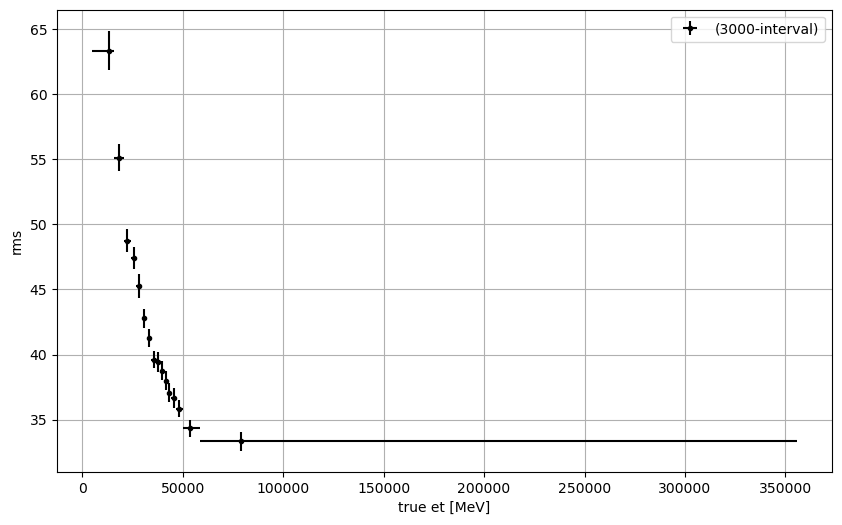

In [18]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=Zee.testing_dataset["et"].values,
    y_values=(Zee.y_test - Zee.y_pred),
    interval=3000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

In [19]:
y_e

[63.365715,
 55.125698,
 48.763042,
 47.431953,
 45.239418,
 42.781254,
 41.25372,
 39.605415,
 39.425404,
 38.769184,
 38.003178,
 37.071888,
 36.688564,
 35.8505,
 34.32109,
 33.343395]

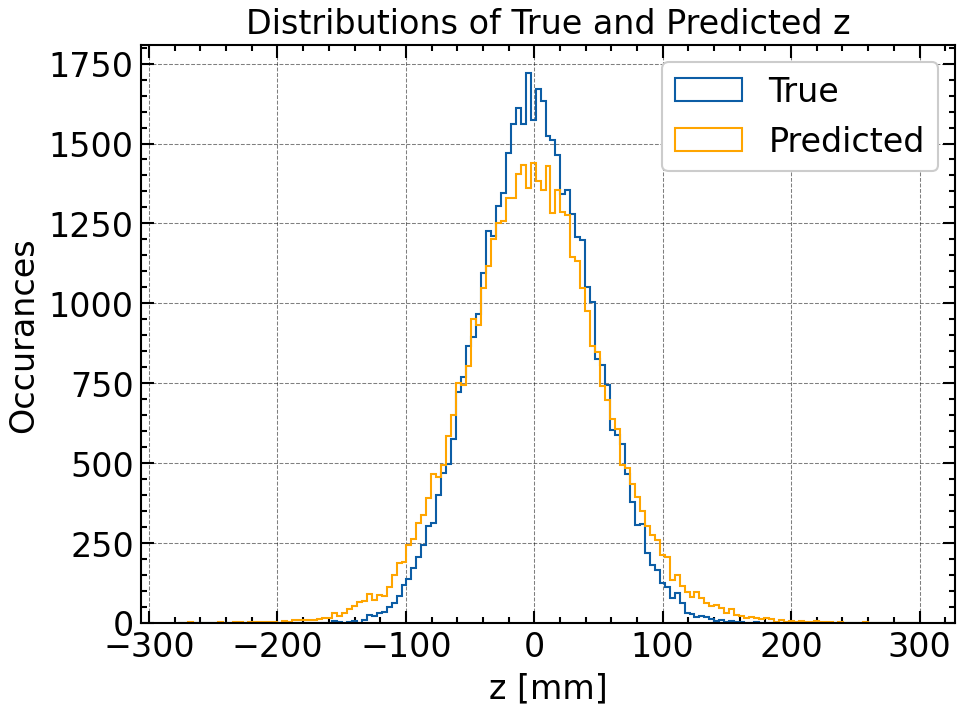

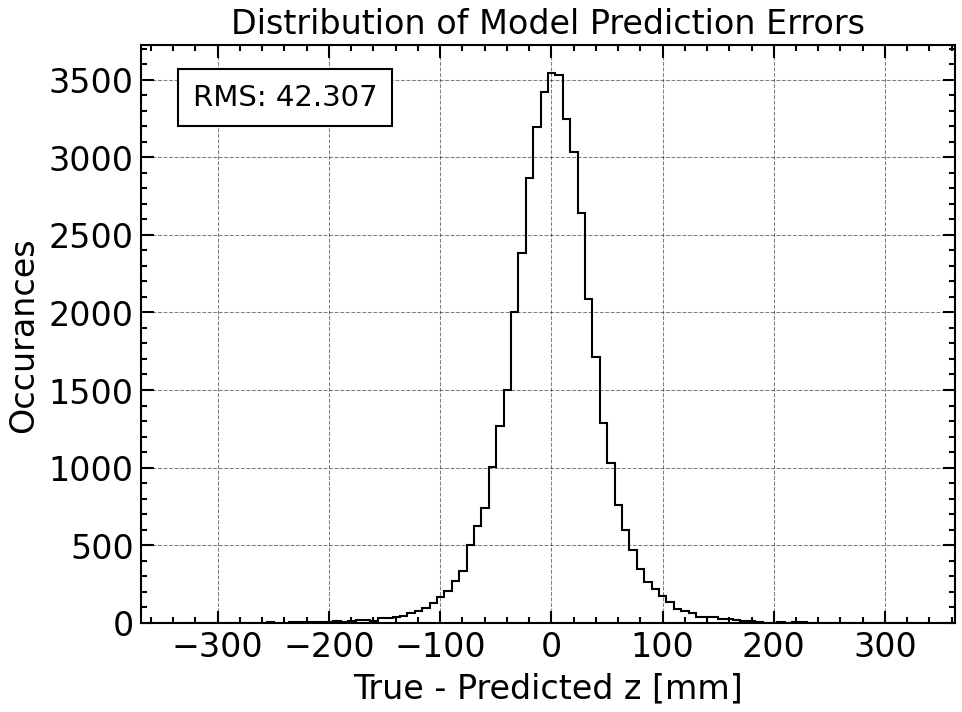

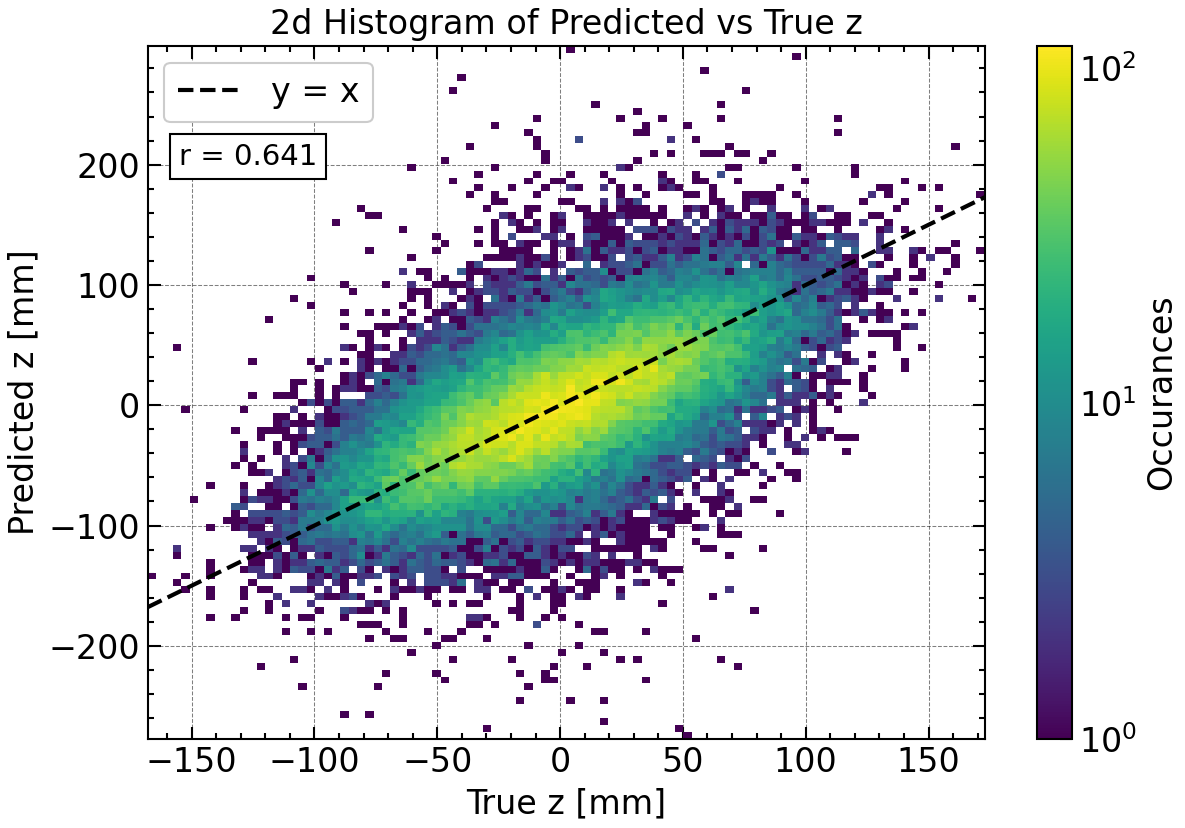

In [20]:
Y_test = Zee.y_test
Y_pred = Zee.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

In [21]:
np.sqrt((Zee.z**2).mean())

43.93114480810712

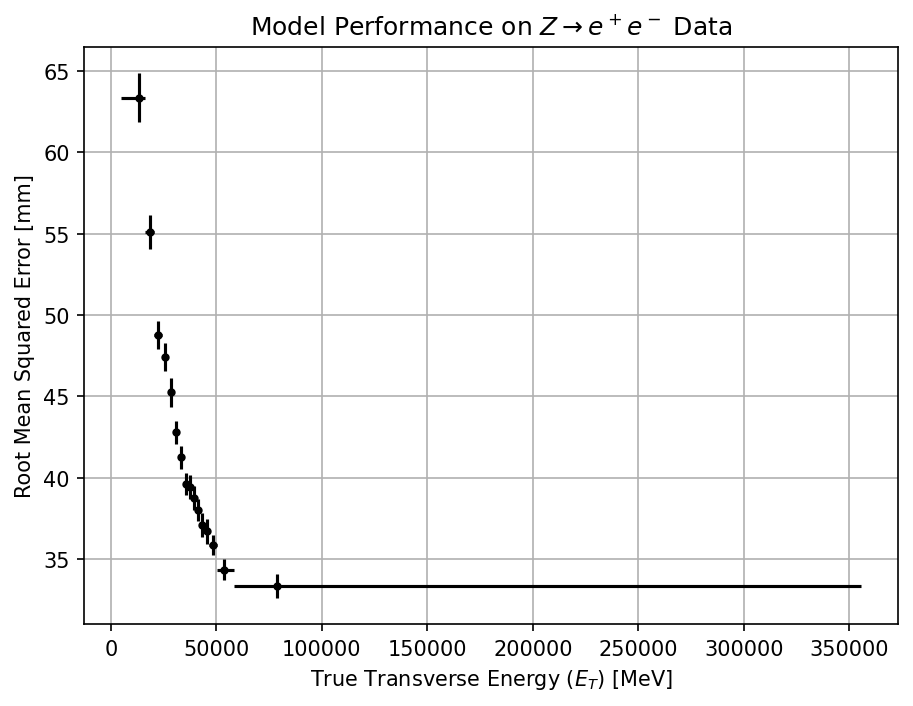

In [26]:
plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(x_e, y_e, xerr=x_u_e, yerr=u_e, fmt=".", color="k")

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title(r"Model Performance on $Z \rightarrow e^+e^-$ Data")


plt.grid()
plt.show()